# Binary Classification with White Wine -> Good (0-5) and Better (6-10) Classes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(precision = 3, suppress = True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.losses import BinaryCrossentropy

## Load Data

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
column_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                'alcohol', 'quality']

raw_dataset = pd.read_csv(url, sep = ';')

In [4]:
dataset = raw_dataset.copy()
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Split the dataset into a training set and a test set**

In [5]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

** Split features from labels and convert quality scores to two classes -> 0 (scores 0-5) and 1 (scores 6-10) **

In [6]:
def convert_to_binary(row):
    if row <= 5:
        return 0
    return 1

In [7]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('quality')
binary_train_labels = train_labels.apply(convert_to_binary)
test_labels = test_features.pop('quality')
binary_test_labels = test_labels.apply(convert_to_binary)


In [8]:
train_labels.head()

2762    5
42      6
1419    7
3664    8
2125    5
Name: quality, dtype: int64

In [9]:
binary_train_labels.head()

2762    0
42      1
1419    1
3664    1
2125    0
Name: quality, dtype: int64

## Normalization Layer

In [10]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[  6.859   0.278   0.335   6.38    0.046  35.172 137.689   0.994   3.187
   0.489  10.517]


** Helper plotting function **

In [11]:
def plot(history):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color = color)
    lns1 = ax1.plot(history.history['loss'], label = 'loss', color = color)
    lns2 = ax1.plot(history.history['val_loss'], label = 'val_loss', color = color, linestyle = 
    'dashed')
    ax1.tick_params(axis = 'y', labelcolor = color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color = color)  
    lns3 = ax2.plot(history.history['accuracy'], label = 'accuracy', color = color)
    lns4 = ax2.plot(history.history['val_accuracy'], label = 'val_accuracy', color = color, 
    linestyle = 'dashed')
    ax2.tick_params(axis = 'y', labelcolor = color)

    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, loc = 'center right')

    fig.tight_layout() 
    plt.show()

## Build and Compile Model

** Add early stopping callback to avoid long unnecessary training times **

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True)

In [13]:
def build_and_compile_model():
  model = keras.Sequential([
      normalizer,
      layers.Dense(16, activation = 'relu'),
      layers.Dropout(0.5),
      layers.Dense(1, activation = 'sigmoid')
  ])

  model.compile(loss = BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])
  return model

In [14]:
model = build_and_compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 11)                23        
_________________________________________________________________
dense (Dense)                (None, 16)                192       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 232
Trainable params: 209
Non-trainable params: 23
_________________________________________________________________


In [15]:
%%time
history = model.fit(
    train_features, binary_train_labels,
    validation_split = 0.2,
    verbose=0, epochs = 1000, callbacks = [callback])

CPU times: user 47 s, sys: 6.78 s, total: 53.8 s
Wall time: 34.6 s


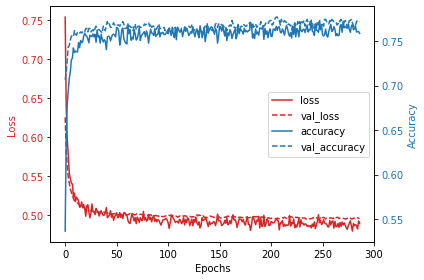

In [16]:
plot(history)

In [17]:
model.evaluate(test_features, binary_test_labels)

31/31 [==============================] - 0s 2ms/step - loss: 0.4814 - accuracy: 0.7755


[0.4814034104347229, 0.7755101919174194]